# Logistic Regression

**Learning Objectives:**
  * Reframe the median house value predictor (from the preceding exercises) as a binary classification model
  * Compare the effectiveness of logisitic regression vs linear regression for a binary classification problem

As in the prior exercises, we're working with the [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), but this time we will turn it into a binary classification problem by predicting whether a city block is a high-cost city block. We'll also revert to the default features, for now.

## Frame the Problem as Binary Classification

The target of our dataset is `median_house_value` which is a numeric (continuous-valued) feature. We can create a boolean label by applying a threshold to this continuous value.

Given features describing a city block, we wish to predict if it is a high-cost city block. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for median house value (a value of approximately 265000). All house values above the threshold are labeled `1`, and all others are labeled `0`.

In [3]:
import math
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [56]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", 
                                           sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
338,-116.9,32.9,15.0,3560.0,593.0,1757.0,574.0,5.1,185300.0
13912,-122.0,37.6,16.0,4371.0,889.0,2530.0,817.0,4.7,256000.0
12972,-121.8,39.8,39.0,568.0,127.0,267.0,129.0,1.8,78100.0
15189,-122.3,37.9,52.0,2041.0,270.0,671.0,253.0,6.9,417500.0
16327,-122.5,37.7,42.0,1667.0,395.0,1041.0,387.0,4.0,273700.0
...,...,...,...,...,...,...,...,...,...
6312,-118.2,33.9,43.0,793.0,235.0,736.0,231.0,0.9,90400.0
13217,-121.9,37.3,52.0,1575.0,284.0,629.0,284.0,5.6,312000.0
16965,-124.2,40.8,46.0,1975.0,346.0,791.0,349.0,3.8,81800.0
4467,-118.0,34.1,39.0,2302.0,412.0,1590.0,406.0,4.8,273800.0


In [8]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "households",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] /
                                              california_housing_dataframe["population"])
    return processed_features

In [57]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [58]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("training examples")
display.display(training_examples.describe())
print("validation_examples")
display.display(validation_examples.describe())
print("training_targets")
display.display(training_targets.describe())
print("validation targets")
display.display(validation_targets.describe())

training examples


,latitude,longitude,households,housing_median_age,total_rooms,total_bedrooms,population,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,499.4,28.5,2639.8,537.8,1424.9,0.0,2.0
std,2.1,2.0,379.0,12.6,2148.1,415.6,1135.8,0.0,1.2
min,32.5,-124.3,1.0,1.0,2.0,1.0,3.0,0.0,0.0
25%,33.9,-121.8,282.0,18.0,1463.8,298.0,792.0,0.0,1.5
50%,34.2,-118.5,409.5,28.0,2126.0,434.0,1165.0,0.0,1.9
75%,37.7,-118.0,603.0,37.0,3153.0,647.0,1719.2,0.0,2.3
max,42.0,-114.5,5050.0,52.0,32054.0,5290.0,35682.0,0.0,55.2


validation_examples


,latitude,longitude,households,housing_median_age,total_rooms,total_bedrooms,population,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,505.5,28.7,2652.8,543.3,1440.9,0.0,2.0
std,2.1,2.0,397.4,12.6,2254.6,435.3,1176.4,0.0,1.0
min,32.5,-124.3,4.0,2.0,20.0,3.0,17.0,0.0,0.3
25%,33.9,-121.7,281.0,18.0,1458.8,294.0,781.8,0.0,1.5
50%,34.2,-118.5,408.0,29.0,2131.5,433.0,1173.0,0.0,1.9
75%,37.7,-118.0,608.0,37.0,3146.5,652.0,1732.2,0.0,2.3
max,41.9,-114.3,6082.0,52.0,37937.0,6445.0,28566.0,0.0,29.4


training_targets


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


validation targets


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


## How Would Linear Regression Fare?
To see why logistic regression is effective, let us first train a naive model that uses linear regression. This model will use labels with values in the set `{0, 1}` and will try to predict a continuous value that is as close as possible to `0` or `1`. Furthermore, we wish to interpret the output as a probability, so it would be ideal if the output will be within the range `(0, 1)`. We would then apply a threshold of `0.5` to determine the label.

Run the cells below to train the linear regression model using [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor).

In [59]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [60]:
def my_input_fun(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
    

In [61]:
def train_linear_regressor_model(learning_rate, steps, batch_size, training_examples, training_targets,
                                 validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns = construct_feature_columns(training_examples),
                                                    optimizer = my_optimizer)
    training_input_fun = lambda:my_input_fun(training_examples, training_targets["median_house_value_is_high"],
                                             batch_size = batch_size)
    predict_training_input_fun = lambda:my_input_fun(training_examples, training_targets["median_house_value_is_high"],
                                                     num_epochs = 1, shuffle = False)
    predict_validation_input_fun = lambda:my_input_fun(
        validation_examples, validation_targets["median_house_value_is_high"], num_epochs = 1, shuffle = False)
   
    print("training model...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        linear_regressor.train(input_fn = training_input_fun, steps = steps_per_period)
        training_predictions = linear_regressor.predict(input_fn = predict_training_input_fun)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fun)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(
            validation_predictions, validation_targets))
        print("Period %02d % 0.2f" %(period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("model training finished")
    
    plt.ylabel("RMSE")
    plt.xlabel("Period")
    plt.title("RMSE vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label = "training")
    plt.plot(validation_rmse, label = "validation")
    plt.legend()
    
    return linear_regressor

training model...
RMSE (on training data): 
Period 00  0.45
Period 01  0.45
Period 02  0.45
Period 03  0.45
Period 04  0.45
Period 05  0.45
Period 06  0.45
Period 07  0.45
Period 08  0.44
Period 09  0.44
model training finished


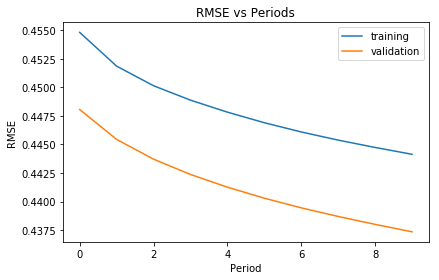

In [62]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 1: Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and that targets, can we calculate `LogLoss`?

### Solution

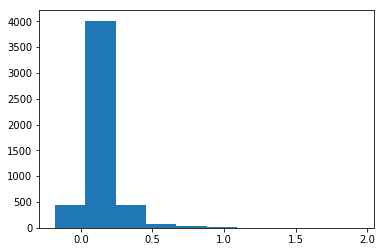

In [63]:
predict_validation_input_fun = lambda:my_input_fun(
        validation_examples, validation_targets["median_house_value_is_high"], num_epochs = 1, shuffle = False)
validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fun)
validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
_ = plt.hist(validation_predictions)

## Task 2: Train a Logistic Regression Model and Calculate LogLoss on the Validation Set

To use logistic regression, simply use [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) instead of `LinearRegressor`. Complete the code below.

**NOTE**: When running `train()` and `predict()` on a `LinearClassifier` model, you can access the real-valued predicted probabilities via the `"probabilities"` key in the returned dict—e.g., `predictions["probabilities"]`. Sklearn's [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) function is handy for calculating LogLoss using these probabilities.

In [66]:
def train_linear_classifier_model(learning_rate, steps, batch_size, training_examples, training_targets, 
                                  validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(training_examples), optimizer = my_optimizer)
    training_input_fun = lambda : my_input_fun(training_examples, training_targets["median_house_value_is_high"], 
                                               batch_size = batch_size)
    predict_training_input_fun = lambda : my_input_fun(training_examples, training_targets["median_house_value_is_high"],
                                                       num_epochs = 1, shuffle = False)
    predict_validation_input_fun = lambda : my_input_fun(validation_examples, 
                                                         validation_targets["median_house_value_is_high"], 
                                                         num_epochs = 1, shuffle = False)
    print("training model...")
    print("Log loss (on training data)")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        linear_classifier.train(input_fn = training_input_fun, steps = steps_per_period)
        training_probabilities = linear_classifier.predict(input_fn = predict_training_input_fun)
        training_probabilities = np.array([item["probabilities"] for item in training_probabilities])
        validation_probabilities = linear_classifier.predict(input_fn = predict_validation_input_fun)
        validation_probabilities = np.array([item["probabilities"] for item in validation_probabilities])
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        print("Period %02d : %0.2f" %(period, training_log_loss))
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished")
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label= "training")
    plt.plot(validation_log_losses, label = "validation")
    plt.legend()
    return linear_classifier

training model...
Log loss (on training data)
Period 00 : 0.61
Period 01 : 0.59
Period 02 : 0.58
Period 03 : 0.57
Period 04 : 0.56
Period 05 : 0.56
Period 06 : 0.55
Period 07 : 0.55
Period 08 : 0.55
Period 09 : 0.54
Model training finished


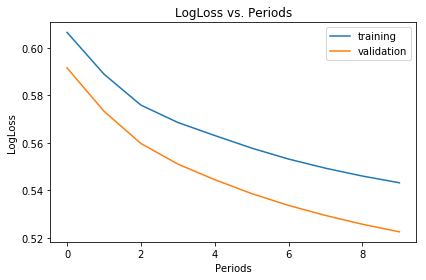

In [67]:
linear_classifier = train_linear_classifier_model(learning_rate = 0.000005, steps = 500, batch_size = 20, 
                                                  training_examples = training_examples, 
                                                  training_targets = training_targets,
                                                  validation_examples = validation_examples, 
                                                  validation_targets = validation_targets)

## Task 3: Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

In [72]:
evaluation_metrics = linear_classifier.evaluate(input_fn = predict_validation_input_fun)
print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" %evaluation_metrics['accuracy'])

AUC on the validation set: 0.71
Accuracy on the validation set: 0.75


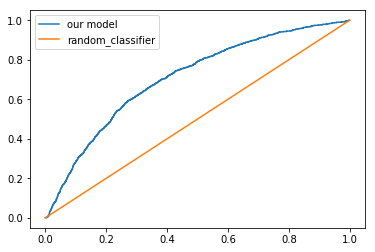

In [74]:
validation_probabilities = linear_classifier.predict(input_fn = predict_validation_input_fun)
validation_probabilities = np.array([item["probabilities"][1] for item in validation_probabilities])
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label = "our model")
plt.plot([0, 1], [0, 1], label = "random_classifier")
_ = plt.legend(loc = 2)

training model...
Log loss (on training data)
Period 00 : 0.51
Period 01 : 0.50
Period 02 : 0.49
Period 03 : 0.48
Period 04 : 0.48
Period 05 : 0.48
Period 06 : 0.48
Period 07 : 0.48
Period 08 : 0.48
Period 09 : 0.48
Model training finished
AUC on the validation set: 0.81
Accuracy on the validation set: 0.79


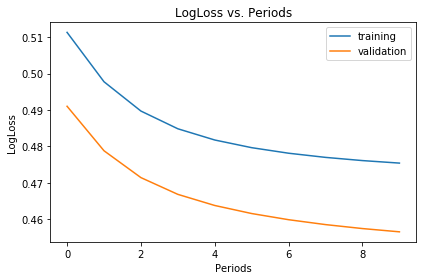

In [77]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fun)

print ("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])